# Comparação de Performance: Dijkstra Clássico vs. Dijkstra com Min-Heap
Este projeto realiza uma análise de benchmark comparativa entre duas implementações do algoritmo de Dijkstra (Clássica $O(V^2)$ e com Min-Heap $O((V+E)\log V)$) e a versão otimizada da biblioteca NetworkX. O objetivo é avaliar o impacto prático da complexidade algorítmica no tempo de execução e na pegada de carbono (CO₂), medidos em grafos aleatórios de tamanhos crescentes (100 a 100.000 nós).

### Importação de Bibliotecas

Esta célula importa todas as bibliotecas necessárias para o projeto, incluindo `numpy` para operações numéricas, `networkx` para a manipulação de grafos, `matplotlib` e `plotly` para a visualização de dados, e `codecarbon` para o rastreamento de emissões de CO₂.

In [3]:
import random
import numpy as np
import networkx as nx
import math
import time
import pandas as pd
import scipy.stats as st
import os
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import HTML, display # Usado para exibir HTML

### Geração dos Grafos de Teste
Esta célula define a lógica para criar os grafos que serão usados no benchmark.

- A semente (seed) garante que a geração aleatória (grafos, pesos) seja sempre a mesma, permitindo a reprodutibilidade dos resultados.
- A função `generate_weighted_connected_graph(n, seed)` gera um grafo aleatório, garante que o grafo seja conectado (extraindo o componente gigante, se necessário) e adiciona pesos inteiros aleatórios (entre 1 e 10) em todas as arestas.
- A função `main()` é um script de teste para validar a função acima. Ele itera sobre a lista GRAPH_SIZES, gera um grafo para cada tamanho e imprime suas propriedades (número de nós, arestas, tempo de geração).

In [ ]:

# --- Configuração de Reprodutibilidade ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Parâmetros de Geração ---
GRAPH_SIZES = [100, 500, 1_000, 5_000, 10_000, 50_000]
WEIGHT_RANGE = (1, 10) # Pesos inteiros positivos (1 a 10)

def generate_weighted_connected_graph(n, seed):
    """
    Gera um grafo ponderado e conectado usando o modelo gnp_random_graph.

    1. Usa p = 2*ln(n)/n para ter alta probabilidade de conectividade.
    2. Se não estiver conectado, extrai o componente gigante (como solicitado).
    3. Adiciona pesos inteiros aleatórios às arestas.
    """

    # 1. Calcular probabilidade p para alta chance de conectividade
    # O limiar de conectividade para gnp(n,p) é p ~ ln(n)/n
    # Usamos um fator de 2 para segurança.
    if n < 2:
        return nx.Graph()

    p = 2 * math.log(n) / n

    # 2. Gerar o grafo inicial
    # Passamos o 'seed' para a função do numpy que o networkx usa
    G = nx.gnp_random_graph(n, p, seed=np.random.RandomState(seed))

    # 3. Garantir conectividade (usando o componente gigante)
    if nx.is_connected(G):
        print(f"Grafo (n={n}) gerado já é conectado.")
        G_connected = G
    else:
        print(f"Grafo (n={n}) não é conectado. Extraindo componente gigante...")

        # Encontra o maior componente conectado (componente gigante)
        giant_component_nodes = max(nx.connected_components(G), key=len)

        # Cria um subgrafo com apenas esses nós.
        # .copy() é crucial para criar um novo grafo independente
        G_connected = G.subgraph(giant_component_nodes).copy()
        G_connected = nx.convert_node_labels_to_integers(G_connected, first_label=0)

        print(f"Componente gigante extraído. Nós reais: {G_connected.number_of_nodes()}")

    # 4. Adicionar pesos inteiros positivos ao grafo
    min_w, max_w = WEIGHT_RANGE
    for u, v in G_connected.edges():
        # Usamos 'random.randint' que foi semeado com a semente global
        weight = random.randint(min_w, max_w)
        G_connected[u][v]['weight'] = weight

    return G_connected

def main():
    print(f"Iniciando geração de grafos com SEED={SEED}\n")

    generated_graphs = {}

    for n in GRAPH_SIZES:
        print(f"--- Processando n = {n:,} ---")

        if n > 20000:
             print("AVISO: Este tamanho de grafo é grande e pode")
             print("       consumir muita RAM e levar algum tempo.")

        t_start = time.time()

        try:
            # Usamos a semente SEED + n para garantir que cada
            # tamanho de grafo tenha sua própria semente única,
            # mas ainda reprodutível.
            G = generate_weighted_connected_graph(n, seed=SEED + n)

            t_end = time.time()

            print(f"Nós (real):    {G.number_of_nodes():,}")
            print(f"Arestas:       {G.number_of_edges():,}")
            print(f"Conectado:     {nx.is_connected(G)}")
            print(f"Tempo:         {t_end - t_start:.4f}s")

            # Você pode armazenar os grafos se tiver memória
            # generated_graphs[n] = G

            # Exemplo de verificação de peso em uma aresta (se houver arestas)
            if G.number_of_edges() > 0:
                # Pega a primeira aresta
                u, v = list(G.edges())[0]
                print(f"Peso de exemplo (aresta {u}-{v}): {G[u][v]['weight']}")

        except MemoryError:
            print(f"ERRO: Estouro de memória (MemoryError) ao tentar gerar grafo com n={n:,}.")
            print("Este é o limite da sua máquina.")
            print("Interrompendo a execução.")
            break
        except Exception as e:
            print(f"Ocorreu um erro inesperado com n={n:,}: {e}")
            break

        print("-" * 30 + "\n")

    print("Geração de grafos concluída.")

if __name__ == "__main__":
    main()

Iniciando geração de grafos com SEED=42

--- Processando n = 100 ---
Grafo (n=100) gerado já é conectado.
Nós (real):    100
Arestas:       487
Conectado:     True
Tempo:         0.0033s
Peso de exemplo (aresta 0-23): 2
------------------------------

--- Processando n = 500 ---
Grafo (n=500) gerado já é conectado.
Nós (real):    500
Arestas:       3,114
Conectado:     True
Tempo:         0.0273s
Peso de exemplo (aresta 0-72): 5
------------------------------

--- Processando n = 1,000 ---
Grafo (n=1000) gerado já é conectado.
Nós (real):    1,000
Arestas:       6,921
Conectado:     True
Tempo:         0.1127s
Peso de exemplo (aresta 0-125): 10
------------------------------

--- Processando n = 5,000 ---
Grafo (n=5000) gerado já é conectado.
Nós (real):    5,000
Arestas:       42,680
Conectado:     True
Tempo:         2.1214s
Peso de exemplo (aresta 0-50): 8
------------------------------

--- Processando n = 10,000 ---
Grafo (n=10000) gerado já é conectado.
Nós (real):    10,000
Ares

KeyboardInterrupt: 

#### Algoritmo de Dijkstra Clássico

Esta célula implementa a versão clássica do algoritmo de Dijkstra, que encontra o caminho mais curto de um nó inicial para todos os outros nós em um grafo. A implementação utiliza uma lista para armazenar as distâncias e um conjunto para rastrear os nós visitados.

In [3]:
# O(V^2 + E) time | O(V) space - where V is the number of vertices and E is the number of edges in the input graph
def dijkstra_classico(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest path from a starting node to all other nodes in a graph.

    Args:
        start (int): The starting node index.
        edges (list of list): Adjacency list representing the graph. Each index corresponds to a vertex,
                              and each entry is a list of pairs [destination, weight].

    Returns:
        list: A list of the shortest distances from the starting node to each node. If a node is not reachable,
              the distance is -1.
    """
    numberOfVertices = len(edges)

    # Initialize the minimum distances for all vertices as infinity
    # except the starting vertex which is set to 0.
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Keep track of visited nodes to avoid reprocessing them.
    visited = set()

    # Continue processing nodes until all have been visited.
    while len(visited) != numberOfVertices:
        # Find the vertex with the smallest known distance that has not been visited.
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)

        # If the smallest distance is infinity, all remaining vertices are unreachable.
        if currentMinDistance == float("inf"):
            break

        # Mark the current vertex as visited.
        visited.add(vertex)

        # Iterate through all the neighbors of the current vertex.
        for edge in edges[vertex]:
            destination, distanceToDestination = edge

            # Skip the neighbor if it has already been visited.
            if destination in visited:
                continue

            # Calculate the new potential path distance to the neighbor.
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Update the shortest distance to the neighbor if the new path is shorter.
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance

    # Replace any remaining infinity distances with -1 to indicate unreachable nodes.
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))


def getVertexWithMinDistance(distances, visited):
    """
    Helper function to find the vertex with the smallest known distance that has not been visited.

    Args:
        distances (list): A list of the shortest known distances to each vertex.
        visited (set): A set of vertices that have already been visited.

    Returns:
        tuple: The index of the vertex with the smallest distance and its distance value.
    """
    currentMinDistance = float("inf")
    vertex = -1

    # Iterate over all vertices to find the one with the smallest distance.
    for vertexIdx, distance in enumerate(distances):
        # Skip the vertex if it has already been visited.
        if vertexIdx in visited:
            continue

        # Update the current minimum distance and vertex if a smaller distance is found.
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance

    return vertex, currentMinDistance

#### Estrutura de Dados: Min-Heap

A célula abaixo define uma classe `MinHeap`, uma estrutura de dados de heap mínimo. Esta estrutura é essencial para otimizar o algoritmo de Dijkstra, permitindo a recuperação eficiente do nó com a menor distância. A implementação inclui métodos para construir o heap, inserir, remover e atualizar elementos.

In [4]:
class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """
    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
        """
        Updates the distance of a given vertex and restores the heap property.

        Args:
            vertex (int): The vertex whose distance is to be updated.
            value (int): The new distance value.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        # Update the heap with the new (vertex, value) pair
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restore the heap property by sifting up the updated node
        self.siftUp(self.vertexMap[vertex], self.heap)

#### Algoritmo de Dijkstra com Min-Heap

Esta célula contém a implementação do algoritmo de Dijkstra otimizado com a estrutura de dados `MinHeap`. O uso do Min-Heap melhora a eficiência do algoritmo, especialmente para grafos grandes, reduzindo a complexidade de tempo para encontrar o nó com a menor distância.

In [5]:
# O((v + e) * log(v)) time | O(v) space — where v is the number
# of vertices and e is the number of edges in the input graph
def dijkstra_MinHeap(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a starting vertex to all other vertices
    in a weighted graph. The graph is represented using an adjacency list.

    Args:
        start (int): The starting vertex index.
        edges (list of list): An adjacency list where each index represents a vertex, and each entry
                              is a list of [destination, weight] pairs.

    Returns:
        list: A list of minimum distances from the starting vertex to each vertex in the graph.
              If a vertex is unreachable, its distance is represented as -1.
    """
    # Step 1: Initialize the number of vertices in the graph
    numberOfVertices = len(edges)

    # Step 2: Initialize the minimum distances with infinity
    # Set the starting vertex's distance to 0
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Step 3: Initialize the MinHeap to track the vertices and their current shortest distances
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)  # Update the starting vertex's distance to 0

    # Step 4: Process vertices until the heap is empty
    while not minDistancesHeap.isEmpty():
        # Extract the vertex with the smallest known distance
        vertex, currentMinDistance = minDistancesHeap.remove()

        # If the current distance is infinity, no further reachable vertices exist
        if currentMinDistance == float("inf"):
            break

        # Step 5: Relaxation - Update distances for all neighboring vertices
        for edge in edges[vertex]:
            destination, distanceToDestination = edge  # Extract neighbor and weight

            # Calculate the new potential path distance
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # If the new path is shorter, update the distance and the heap
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    # Step 6: Convert unreachable vertices' distances from infinity to -1
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

#### Função Auxiliar de Conversão
Esta célula define a função utilitária `convert_nx_to_adj_list`. Ela serve como uma "ponte" entre o formato de objeto de grafo retornado pela biblioteca `networkx` e o formato de lista de adjacência (uma lista de listas no formato [vizinho, peso]) que as implementações de sala (`dijkstra_classic` e `dijkstra_min_heap`) exigem como entrada.

In [6]:
def convert_nx_to_adj_list(G):
    """
    Converte um grafo networkx (G) para o formato de lista de adjacência
    esperado pelas funções dijkstra_classico e dijkstra_MinHeap.
    """
    num_nodes = G.number_of_nodes()
    # Cria uma lista de listas vazias
    adj_list = [[] for _ in range(num_nodes)]

    # Itera sobre todas as arestas do grafo
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1) # Pega o peso da aresta

        # Grafo não-direcionado: adiciona a aresta nos dois sentidos
        adj_list[u].append([v, weight])
        adj_list[v].append([u, weight])

    return adj_list

# Execução do Benchmark
Esta célula executa o experimento completo.
- Define os parâmetros do benchmark (ALL_SIZES, NUM_REPETITIONS, etc.).
- Verifica o arquivo checkpoint_all_results.pkl e pula os tamanhos de grafo que já foram processados.
- Roda o loop principal. Para cada tamanho de grafo, mede o tempo e as emissões de CO₂ dos três algoritmos (Classic, Heap, NetworkX) ao longo de 20 repetições.
- Atualiza o arquivo checkpoint_all_results.pkl após cada tamanho de grafo, garantindo que o progresso não seja perdido.
- Ao final, calcula as estatísticas (média, desvio padrão) e salva a tabela de resumo.

In [35]:
!pip install codecarbon


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# --- Configurações ---
output_dir = "resultados_benchmark"
os.makedirs(output_dir, exist_ok=True)
print(f"Resultados serão salvos em: {output_dir}/")

# Arquivo de checkpoint para salvar o progresso
checkpoint_file = os.path.join(output_dir, "checkpoint_all_results.pkl")

print(f"--- Iniciando Benchmark Completo de Dijkstra (Com Tempo e CO₂) ---")

# --- Parâmetros do Benchmark ---

# Passo 1: "Validar inicialmente"
# DESCOMENTE A LINHA ABAIXO para um teste rápido (2-3 minutos)
# ALL_SIZES = [100, 500, 1_000]

# Passo 2: "Experimento completo"
# COMENTE A LINHA ACIMA E USE ESTA para o experimento real
ALL_SIZES = [50_000]
print(f"\nConfiguração de tamanhos: {ALL_SIZES}")

NUM_REPETITIONS = 20
NUM_SOURCE_NODES = 5
CONFIDENCE_LEVEL = 0.95
SEED = 42

# Para garantir reprodutibilidade nos experimentos
random.seed(SEED)
np.random.seed(SEED)

# --- Carregar Checkpoint ---
if os.path.exists(checkpoint_file):
    print(f"Carregando checkpoint encontrado em: {checkpoint_file}")
    try:
        with open(checkpoint_file, 'rb') as f:
            all_results = pickle.load(f)

        processed_n = set(item['n'] for item in all_results)
        print(f"Tamanhos já processados: {sorted(list(processed_n))}")

        ALL_SIZES = [n for n in ALL_SIZES if n not in processed_n]
        print(f"Tamanhos restantes a processar: {ALL_SIZES}")

        if not ALL_SIZES and processed_n:
             print("Todos os tamanhos já foram processados. Pulando para a análise.")

    except Exception as e:
        print(f"Erro ao carregar checkpoint: {e}. Começando do zero.")
        all_results = []
else:
    print("Nenhum checkpoint encontrado. Começando do zero.")
    all_results = []

# --- Inicializa o CodeCarbon Tracker ---
tracker = EmissionsTracker(output_dir=output_dir,
                           save_to_file=False,
                           log_level="error",
                           measure_power_secs=1,
                          )

# --- Função auxiliar para calcular estatísticas ---
def calculate_stats(data_array, confidence_level):
    """Calcula média, desvio padrão e IC para um array de dados."""
    data_clean = data_array[~np.isnan(data_array)]

    if len(data_clean) < 2:
        mean_val = np.mean(data_clean) if len(data_clean) > 0 else 0
        std_dev = np.nan
        ci_low = np.nan
        ci_high = np.nan
        n_obs = len(data_clean)
    else:
        mean_val = np.mean(data_clean)
        std_dev = np.std(data_clean, ddof=1)
        n_obs = len(data_clean)

        ci = st.t.interval(confidence=confidence_level,
                           df=n_obs - 1,
                           loc=mean_val,
                           scale=st.sem(data_clean))

        ci_low, ci_high = ci

    return mean_val, std_dev, ci_low, ci_high, n_obs

# --- Início do Loop de Benchmark ---
if not ALL_SIZES and all_results:
    print("Nenhum tamanho novo para processar. Pulando loop.")
else:
    for n in ALL_SIZES:
        print(f"\nProcessando n = {n:,}")

        times_v2, emissions_v2 = [], []
        times_heap, emissions_heap = [], []
        times_nx, emissions_nx = [], []

        for rep in range(NUM_REPETITIONS):
            print(f"  Repetição {rep + 1}/{NUM_REPETITIONS}... (n={n:,})", end="")

            G_seed = SEED + n + rep
            G_nx = generate_weighted_connected_graph(n, seed=G_seed)
            adj_list = convert_nx_to_adj_list(G_nx)

            num_nodes_real = G_nx.number_of_nodes()
            if num_nodes_real < NUM_SOURCE_NODES:
                source_nodes = list(range(num_nodes_real))
            else:
                source_nodes = random.sample(range(num_nodes_real), NUM_SOURCE_NODES)

            # 1. Dijkstra Clássico
            try:
                tracker.start()
                start_v2 = time.time()
                for source in source_nodes:
                    dijkstra_classico(source, adj_list)
                end_v2 = time.time()
                emissions_v2_run = tracker.stop() or 0.0
                avg_time_v2 = (end_v2 - start_v2) / NUM_SOURCE_NODES
                avg_emissions_v2 = emissions_v2_run / NUM_SOURCE_NODES
                times_v2.append(avg_time_v2)
                emissions_v2.append(avg_emissions_v2)
            except MemoryError:
                print("\n  ERRO DE MEMÓRIA no Dijkstra Clássico. Pulando este algoritmo.")
                times_v2.append(np.nan)
                emissions_v2.append(np.nan)
            except Exception as e:
                print(f"\n  Erro no Dijkstra Clássico: {e}. Pulando.")
                times_v2.append(np.nan)
                emissions_v2.append(np.nan)

            # 2. Dijkstra com MinHeap
            try:
                tracker.start()
                start_heap = time.time()
                for source in source_nodes:
                    dijkstra_MinHeap(source, adj_list)
                end_heap = time.time()
                emissions_heap_run = tracker.stop() or 0.0
                avg_time_heap = (end_heap - start_heap) / NUM_SOURCE_NODES
                avg_emissions_heap = emissions_heap_run / NUM_SOURCE_NODES
                times_heap.append(avg_time_heap)
                emissions_heap.append(avg_emissions_heap)
            except MemoryError:
                print("\n  ERRO DE MEMÓRIA no Dijkstra (Heap). Pulando este algoritmo.")
                times_heap.append(np.nan)
                emissions_heap.append(np.nan)
            except Exception as e:
                print(f"\n  Erro no Dijkstra (Heap): {e}. Pulando.")
                times_heap.append(np.nan)
                emissions_heap.append(np.nan)

            # 3. NetworkX (Referência)
            try:
                tracker.start()
                start_nx = time.time()
                for source in source_nodes:
                    nx.shortest_path(G_nx, source, weight='weight')
                end_nx = time.time()
                emissions_nx_run = tracker.stop() or 0.0
                avg_time_nx = (end_nx - start_nx) / NUM_SOURCE_NODES
                avg_emissions_nx = emissions_nx_run / NUM_SOURCE_NODES
                times_nx.append(avg_time_nx)
                emissions_nx.append(avg_emissions_nx)
            except MemoryError:
                print("\n  ERRO DE MEMÓRIA no Dijkstra (NetworkX). Pulando este algoritmo.")
                times_nx.append(np.nan)
                emissions_nx.append(np.nan)
            except Exception as e:
                print(f"\n  Erro no Dijkstra (NetworkX): {e}. Pulando.")
                times_nx.append(np.nan)
                emissions_nx.append(np.nan)

            print(f" concluída. (Classic: {avg_time_v2:.4f}s | MinHeap: {avg_time_heap:.4f}s | NX: {avg_time_nx:.4f}s)")

        all_results.append({"n": n, "algo": "Classic", "times": times_v2, "emissions": emissions_v2})
        all_results.append({"n": n, "algo": "MinHeap", "times": times_heap, "emissions": emissions_heap})
        all_results.append({"n": n, "algo": "NetworkX", "times": times_nx, "emissions": emissions_nx})

        # --- Salvar Checkpoint ---
        try:
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(all_results, f)
            print(f"  Resultados para n={n:,} coletados e checkpoint salvo.")
        except Exception as e:
            print(f"  ERRO AO SALVAR CHECKPOINT: {e}")

        print("-" * 30 + "\n")

    print("Loop de benchmark concluído.")

# --- Processamento Final ---
if not all_results:
    print("Nenhum resultado foi coletado. Encerrando o script.")
else:
    print("\nBenchmark concluído. Processando resultados finais...")
    summary_data = []

    for item in all_results:
        n = item['n']
        algo = item['algo']
        times_array = np.array(item['times'])
        emissions_array = np.array(item['emissions'])

        mean_time, std_time, ci_low_time, ci_high_time, n_obs = calculate_stats(times_array, CONFIDENCE_LEVEL)
        mean_co2, std_co2, ci_low_co2, ci_high_co2, _ = calculate_stats(emissions_array, CONFIDENCE_LEVEL)

        summary_data.append({
            "Tamanho (n)": n, "Algoritmo": algo,
            "Tempo Médio (s)": mean_time, "Desvio Padrão (s)": std_time,
            f"IC {CONFIDENCE_LEVEL*100}% Tempo (Inf)": ci_low_time,
            f"IC {CONFIDENCE_LEVEL*100}% Tempo (Sup)": ci_high_time,
            "CO₂ Médio (kg)": mean_co2, "Desvio Padrão (CO₂)": std_co2,
            f"IC {CONFIDENCE_LEVEL*100}% CO₂ (Inf)": ci_low_co2,
            f"IC {CONFIDENCE_LEVEL*100}% CO₂ (Sup)": ci_high_co2,
            "Repetições (N)": n_obs
        })

    df_summary = pd.DataFrame(summary_data)
    df_summary = df_summary.sort_values(by=["Tamanho (n)", "Algoritmo"])

    print("\n--- Tabela de Resultados (Tempo e CO₂) ---")
    try:
        print(df_summary.to_markdown(index=False, floatfmt=(".0f", ".20s", ".8f", ".8f", ".8f", ".8f", ".2e", ".2e", ".2e", ".2e", ".0f")))
    except ImportError:
        print("Módulo 'tabulate' não encontrado. Imprimindo DataFrame padrão.")
        print(df_summary)

    # Salvar tabela em CSV (Localmente)
    table_filename = os.path.join(output_dir, "benchmark_dijkstra_resultados_com_co2.csv")
    df_summary.to_csv(table_filename, index=False)

Resultados serão salvos em: resultados_benchmark/
--- Iniciando Benchmark Completo de Dijkstra (Com Tempo e CO₂) ---

Configuração de tamanhos: [10000]
Carregando checkpoint encontrado em: resultados_benchmark\checkpoint_all_results.pkl
Tamanhos já processados: [100, 500, 1000, 5000]
Tamanhos restantes a processar: [10000]

Processando n = 10,000
  Repetição 1/20... (n=10,000)Grafo (n=10000) gerado já é conectado.
 concluída. (Classic: 3.8137s | MinHeap: 0.0967s | NX: 0.1345s)
  Repetição 2/20... (n=10,000)Grafo (n=10000) gerado já é conectado.
 concluída. (Classic: 3.8061s | MinHeap: 0.0905s | NX: 0.1376s)
  Repetição 3/20... (n=10,000)Grafo (n=10000) gerado já é conectado.
 concluída. (Classic: 3.8143s | MinHeap: 0.0930s | NX: 0.1218s)
  Repetição 4/20... (n=10,000)Grafo (n=10000) gerado já é conectado.
 concluída. (Classic: 3.8080s | MinHeap: 0.0920s | NX: 0.0966s)
  Repetição 5/20... (n=10,000)Grafo (n=10000) gerado já é conectado.
 concluída. (Classic: 3.8087s | MinHeap: 0.1255s |

#### Código para coletar pegada de carbono de MinHeap e NetworkX para n=50.000

In [ ]:
# --- Configurações ---
output_dir = "resultados_benchmark"
os.makedirs(output_dir, exist_ok=True)
print(f"Resultados serão salvos em: {output_dir}/")

print(f"--- Iniciando Benchmark (Focado em MinHeap/NetworkX) ---")

# --- Parâmetros do Benchmark ---
ALL_SIZES = [5000, 10000]
print(f"\nConfiguração de tamanhos: {ALL_SIZES}")

NUM_REPETITIONS = 20
NUM_SOURCE_NODES = 5
CONFIDENCE_LEVEL = 0.95
SEED = 42

# Para garantir reprodutibilidade nos experimentos
random.seed(SEED)
np.random.seed(SEED)

all_results = []

# --- Inicializa o CodeCarbon Tracker ---
tracker = EmissionsTracker(output_dir=output_dir,
                           save_to_file=False,
                           log_level="error",
                           measure_power_secs=0.1, 
                          )

print("Iniciando o CodeCarbon Tracker (pode levar alguns segundos)...")
try:
    tracker.start()
    print("Tracker iniciado com sucesso.")
except Exception as e:
    print(f"ERRO AO INICIAR O TRACKER: {e}")
    raise e


# --- Função auxiliar para calcular estatísticas ---
def calculate_stats(data_array, confidence_level):
    """Calcula média, desvio padrão e IC para um array de dados."""
    data_clean = data_array[~np.isnan(data_array)]

    if len(data_clean) < 2:
        mean_val = np.mean(data_clean) if len(data_clean) > 0 else 0
        std_dev = np.nan
        ci_low = np.nan
        ci_high = np.nan
        n_obs = len(data_clean)
    else:
        mean_val = np.mean(data_clean)
        std_dev = np.std(data_clean, ddof=1)
        n_obs = len(data_clean)

        ci = st.t.interval(confidence=confidence_level,
                           df=n_obs - 1,
                           loc=mean_val,
                           scale=st.sem(data_clean))

        ci_low, ci_high = ci

    return mean_val, std_dev, ci_low, ci_high, n_obs

# --- Início do Loop de Benchmark ---
if not ALL_SIZES and all_results:
    print("Nenhum tamanho novo para processar. Pulando loop.")
else:
    for n in ALL_SIZES:
        print(f"\nProcessando n = {n:,}")

        times_heap, emissions_heap = [], []
        times_nx, emissions_nx = [], []

        for rep in range(NUM_REPETITIONS):
            print(f"  Repetição {rep + 1}/{NUM_REPETITIONS}... (n={n:,})", end="")

            G_seed = SEED + n + rep
            G_nx = generate_weighted_connected_graph(n, seed=G_seed)
            adj_list = convert_nx_to_adj_list(G_nx)

            num_nodes_real = G_nx.number_of_nodes()
            if num_nodes_real < NUM_SOURCE_NODES:
                source_nodes = list(range(num_nodes_real))
            else:
                source_nodes = random.sample(range(num_nodes_real), NUM_SOURCE_NODES)
            
            # Definir valores padrão para o print em caso de exceção
            avg_time_heap, avg_emissions_heap = np.nan, np.nan
            avg_time_nx, avg_emissions_nx = np.nan, np.nan

            # Dijkstra com MinHeap
            try:
                task_name_heap = f"MinHeap_n{n}_rep{rep+1}"
                tracker.start_task(task_name_heap)
                
                start_heap = time.time()
                for source in source_nodes:
                    dijkstra_MinHeap(source, adj_list)
                end_heap = time.time()
                
                emissions_data_heap = tracker.stop_task(task_name_heap)
                emissions_heap_run = emissions_data_heap.emissions if (emissions_data_heap and emissions_data_heap.emissions) else 0.0

                avg_time_heap = (end_heap - start_heap) / NUM_SOURCE_NODES
                avg_emissions_heap = emissions_heap_run / NUM_SOURCE_NODES
                
                times_heap.append(avg_time_heap)
                emissions_heap.append(avg_emissions_heap)
                
            except MemoryError:
                print("\n  ERRO DE MEMÓRIA no Dijkstra (Heap). Pulando este algoritmo.")
                times_heap.append(np.nan)
                emissions_heap.append(np.nan)
            except Exception as e:
                print(f"\n  Erro no Dijkstra (Heap): {e}. Pulando.")
                times_heap.append(np.nan)
                emissions_heap.append(np.nan)

            # NetworkX (Referência)
            try:
                task_name_nx = f"NetworkX_n{n}_rep{rep+1}"
                tracker.start_task(task_name_nx)
                
                start_nx = time.time()
                for source in source_nodes:
                    nx.shortest_path(G_nx, source, weight='weight')
                end_nx = time.time()
                
                emissions_data_nx = tracker.stop_task(task_name_nx)
                
                # Extrair emissões com segurança
                emissions_nx_run = emissions_data_nx.emissions if (emissions_data_nx and emissions_data_nx.emissions) else 0.0

                avg_time_nx = (end_nx - start_nx) / NUM_SOURCE_NODES
                avg_emissions_nx = emissions_nx_run / NUM_SOURCE_NODES
                
                times_nx.append(avg_time_nx)
                emissions_nx.append(avg_emissions_nx)
            except MemoryError:
                print("\n  ERRO DE MEMÓRIA no Dijkstra (NetworkX). Pulando este algoritmo.")
                times_nx.append(np.nan)
                emissions_nx.append(np.nan)
            except Exception as e:
                print(f"\n  Erro no Dijkstra (NetworkX): {e}. Pulando.")
                times_nx.append(np.nan)
                emissions_nx.append(np.nan)

            # Este print agora deve mostrar valores de CO2 consistentes
            print(f" concluída. | MinHeap: {avg_time_heap:.4f}s (CO₂: {avg_emissions_heap:.2e} kg) | NX: {avg_time_nx:.4f}s (CO₂: {avg_emissions_nx:.2e} kg)")

        all_results.append({"n": n, "algo": "MinHeap", "times": times_heap, "emissions": emissions_heap})
        all_results.append({"n": n, "algo": "NetworkX", "times": times_nx, "emissions": emissions_nx})

        # --- Salvar Checkpoint ---
        try:
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(all_results, f)
            print(f"  Resultados para n={n:,} coletados e checkpoint salvo.")
        except Exception as e:
            print(f"  ERRO AO SALVAR CHECKPOINT: {e}")

        print("-" * 30 + "\n")

    print("Loop de benchmark concluído.")

print("Parando o CodeCarbon Tracker...")
tracker.stop()
print("Tracker parado.")

# --- Processamento Final ---
if not all_results:
    print("Nenhum resultado foi coletado. Encerrando o script.")
else:
    print("\nBenchmark concluído. Processando resultados finais...")
    summary_data = []

    for item in all_results:
        n = item['n']
        algo = item['algo']
        times_array = np.array(item['times'])
        emissions_array = np.array(item['emissions'])

        mean_time, std_time, ci_low_time, ci_high_time, n_obs = calculate_stats(times_array, CONFIDENCE_LEVEL)
        mean_co2, std_co2, ci_low_co2, ci_high_co2, _ = calculate_stats(emissions_array, CONFIDENCE_LEVEL)

        summary_data.append({
            "Tamanho (n)": n, "Algoritmo": algo,
            "Tempo Médio (s)": mean_time, "Desvio Padrão (s)": std_time,
            f"IC {CONFIDENCE_LEVEL*100}% Tempo (Inf)": ci_low_time,
            f"IC {CONFIDENCE_LEVEL*100}% Tempo (Sup)": ci_high_time,
            "CO₂ Médio (kg)": mean_co2, "Desvio Padrão (CO₂)": std_co2,
            f"IC {CONFIDENCE_LEVEL*100}% CO₂ (Inf)": ci_low_co2,
            f"IC {CONFIDENCE_LEVEL*100}% CO₂ (Sup)": ci_high_co2,
            "Repetições (N)": n_obs
        })

    df_summary = pd.DataFrame(summary_data)
    df_summary = df_summary.sort_values(by=["Tamanho (n)", "Algoritmo"])

    print("\n--- Tabela de Resultados (Tempo e CO₂) ---")
    try:
        print(df_summary.to_markdown(index=False, floatfmt=(".0f", ".20s", ".8f", ".8f", ".8f", ".8f", ".2e", ".2e", ".2e", ".2e", ".0f")))
    except ImportError:
        print("Módulo 'tabulate' não encontrado. Imprimindo DataFrame padrão.")
        print(df_summary)

    table_filename = os.path.join(output_dir, "benchmark_RAPIDOS_corrigido.csv")
    df_summary.to_csv(table_filename, index=False)
    print(f"\nResultados corrigidos (MinHeap/NetworkX) salvos em: {table_filename}")

Resultados serão salvos em: resultados_benchmark/
--- Iniciando Benchmark (Focado em MinHeap/NetworkX) ---

Configuração de tamanhos: [50000]
Iniciando o CodeCarbon Tracker (pode levar alguns segundos)...
Tracker iniciado com sucesso.

Processando n = 50,000
  Repetição 1/20... (n=50,000)Grafo (n=50000) gerado já é conectado.
 concluída. | MinHeap: 0.6834s (CO₂: 7.66e-06 kg) | NX: 0.7395s (CO₂: 8.29e-06 kg)
  Repetição 2/20... (n=50,000)Grafo (n=50000) gerado já é conectado.
 concluída. | MinHeap: 0.7006s (CO₂: 7.85e-06 kg) | NX: 0.7898s (CO₂: 8.85e-06 kg)
  Repetição 3/20... (n=50,000)Grafo (n=50000) gerado já é conectado.
 concluída. | MinHeap: 0.6766s (CO₂: 7.58e-06 kg) | NX: 0.7131s (CO₂: 7.99e-06 kg)
  Repetição 4/20... (n=50,000)Grafo (n=50000) gerado já é conectado.
 concluída. | MinHeap: 0.6794s (CO₂: 7.61e-06 kg) | NX: 0.7035s (CO₂: 7.88e-06 kg)
  Repetição 5/20... (n=50,000)Grafo (n=50000) gerado já é conectado.
 concluída. | MinHeap: 0.6414s (CO₂: 7.19e-06 kg) | NX: 0.7034s 

### Geração de Gráficos Estáticos
Esta célula carrega o arquivo de resumo csv (gerado pela célula anterior) e o utiliza para criar gráficos estáticos.

As análises são feitas em escalas logarítmicas (para comparar tendências de complexidade) e lineares (para ver a magnitude real das diferenças).

--- Iniciando Geração de Gráficos Estáticos com Barras de Erro ---
Dados de resumo carregados com sucesso de 'resultados_benchmark\benchmark.csv'
Gerando Gráfico 1: Emissão de CO₂ Total (Barras)...


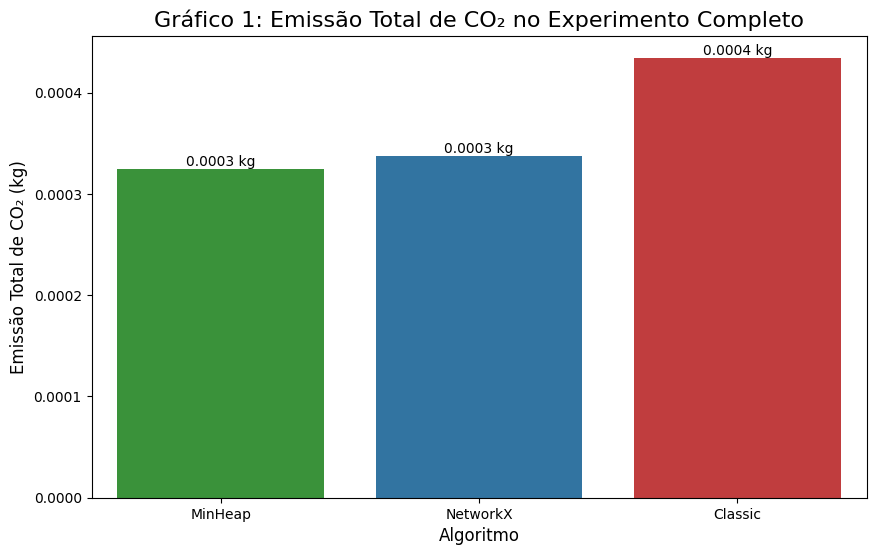

Gerando Gráfico 2: Comparação Lado a Lado (Tempo vs. CO₂)...


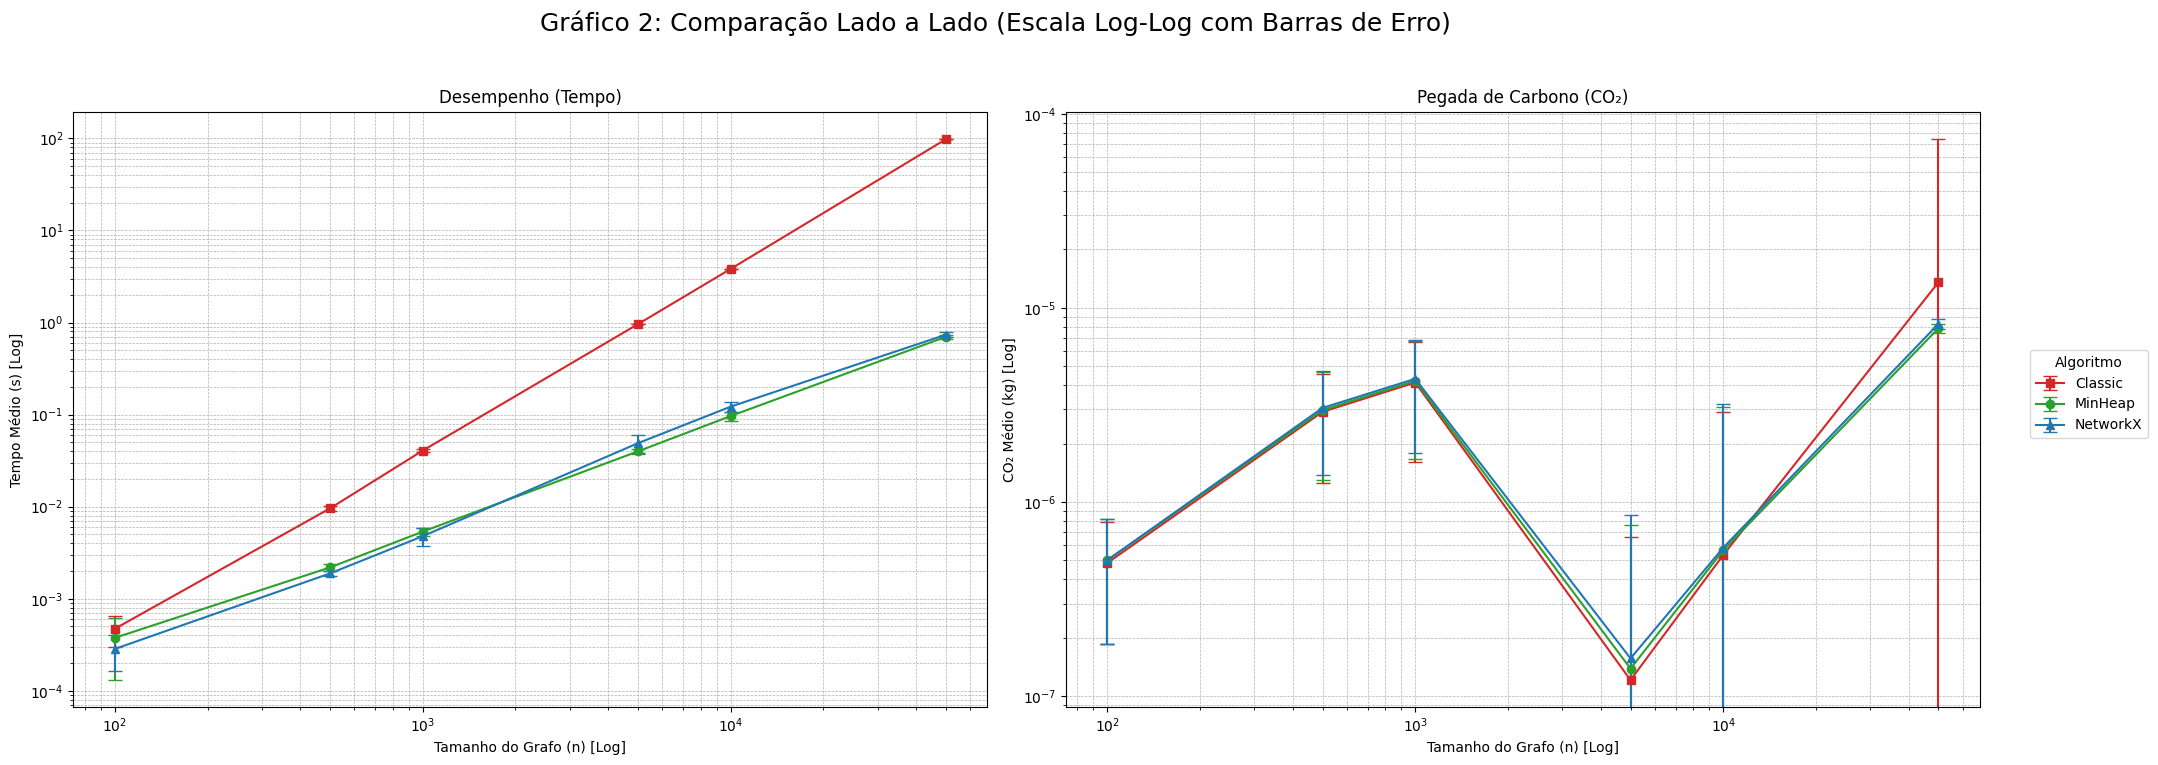

Gerando Gráfico 3: Tempo de Execução (Log vs. Linear)...


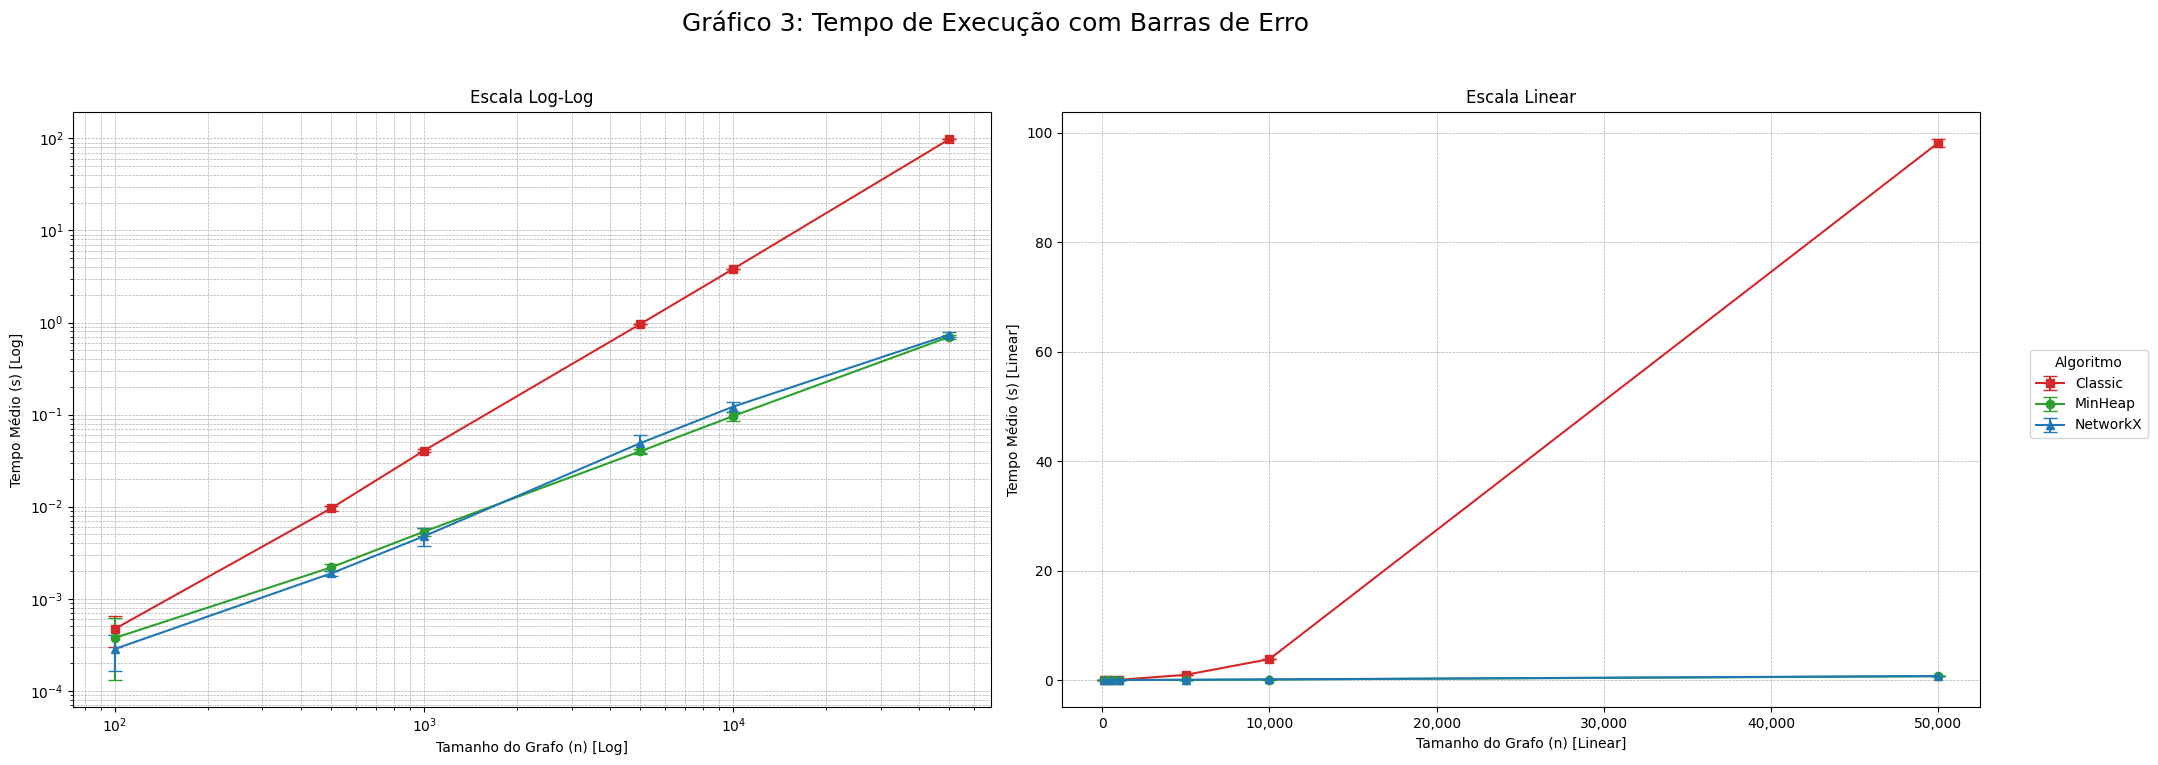

Gerando Gráfico 4: Tempo de Execução (n <= 10.000, Linear)...


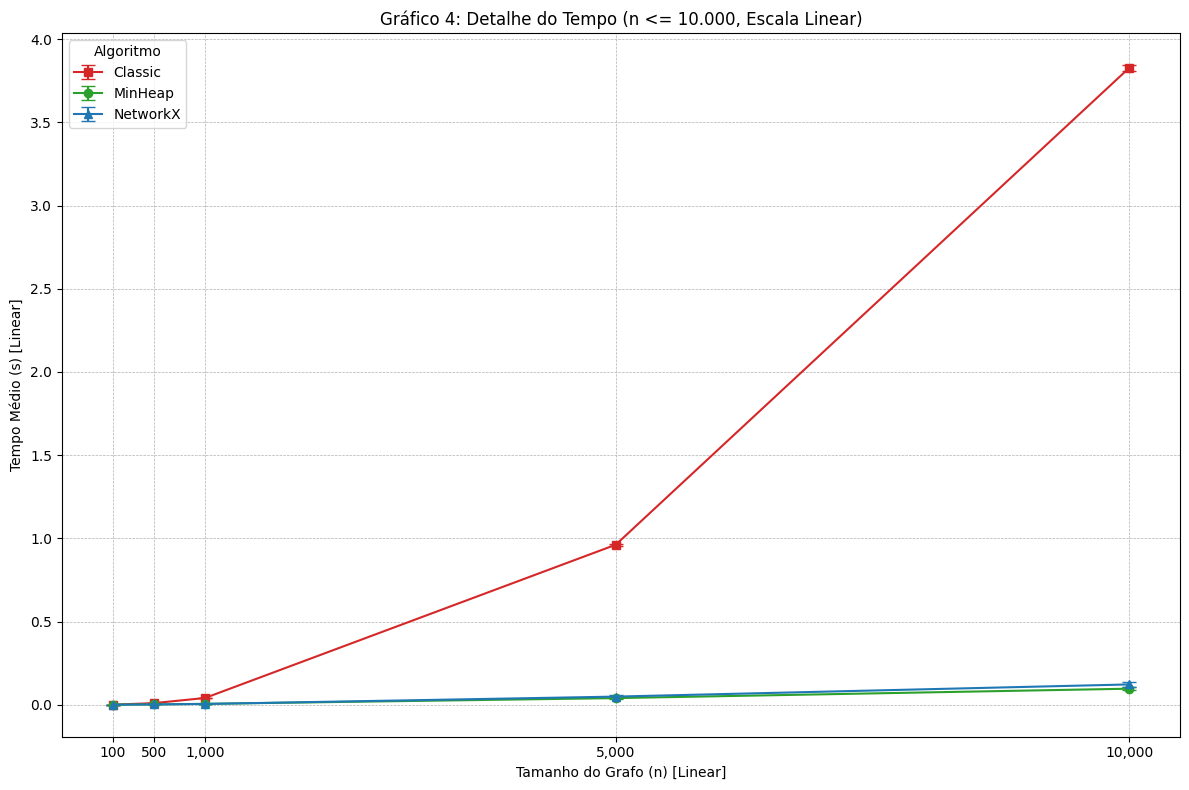

Gerando Gráfico 5: Emissões de CO₂ (Log vs. Linear)...


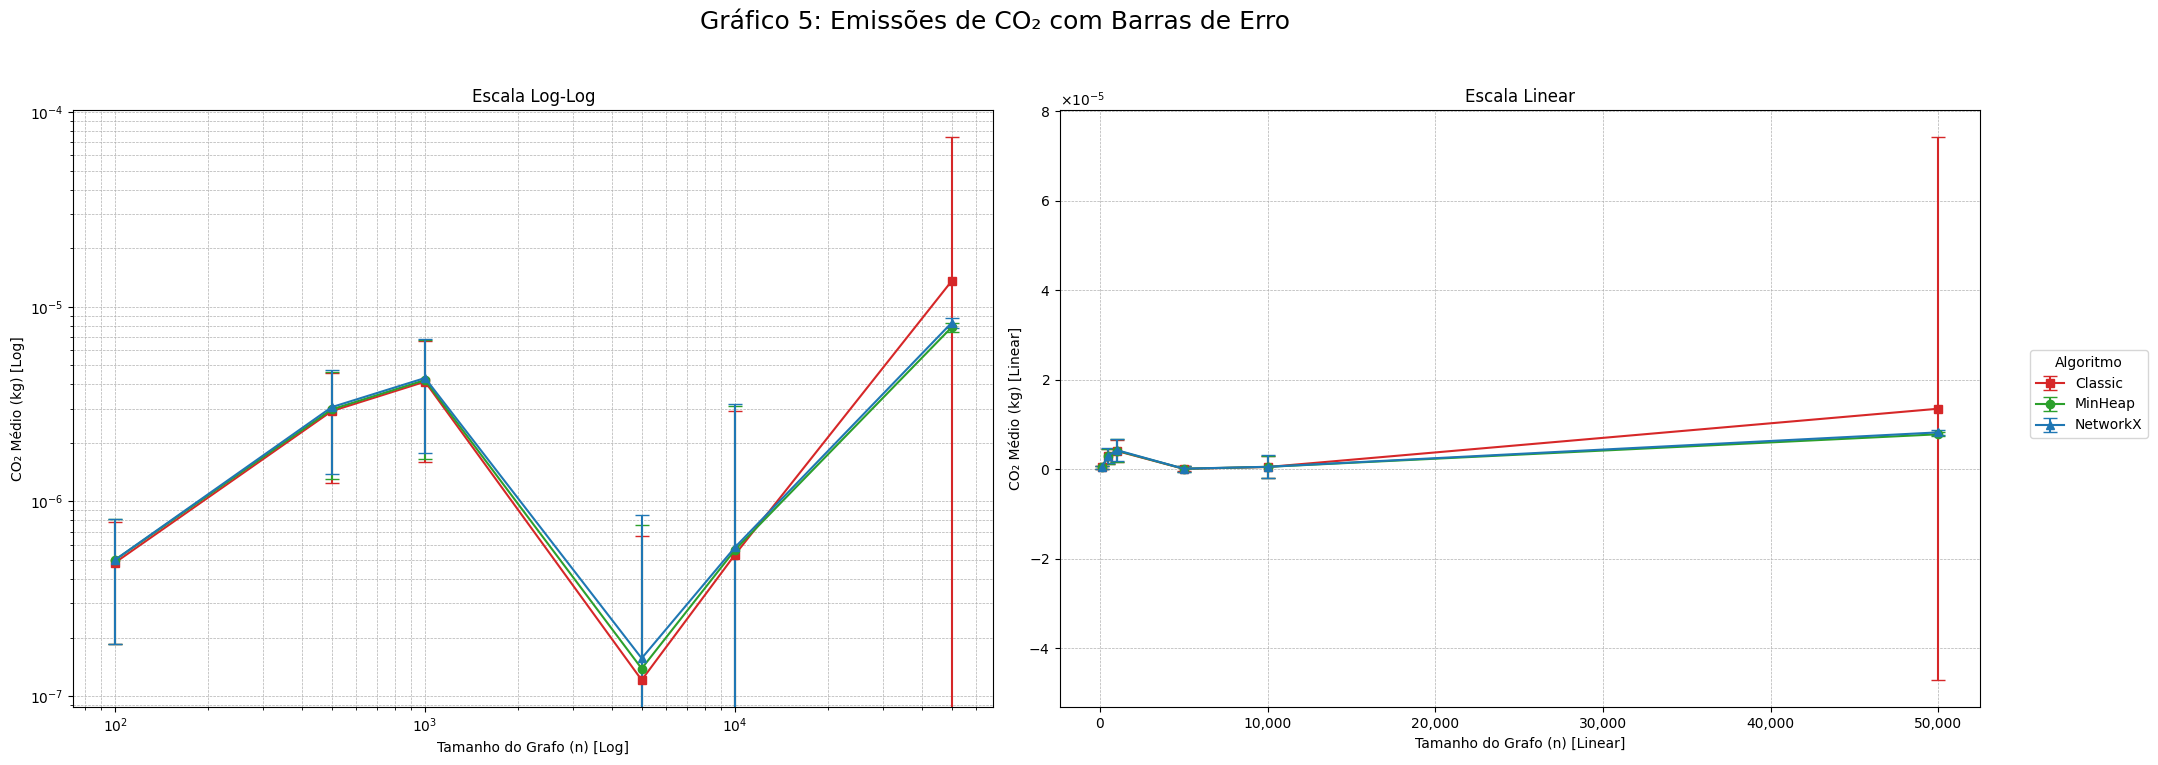


--- Geração Estática Concluída! ---
Gráficos salvos na pasta: 'graficos_estaticos'


In [11]:
print("--- Iniciando Geração de Gráficos Estáticos com Barras de Erro ---")

# --- Configuração ---
output_dir = "graficos_estaticos"
os.makedirs(output_dir, exist_ok=True)

cores = { 'Classic': '#d62728', 'MinHeap': '#2ca02c', 'NetworkX': '#1f77b4' }
marcadores = { 'Classic': 's', 'MinHeap': 'o', 'NetworkX': '^' }

# --- Carregar Dados ---
try:
    df = pd.read_csv(arquivo_final_atualizado)
    print(f"Dados de resumo carregados com sucesso de '{arquivo_final_atualizado}'")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{arquivo_final_atualizado}' não encontrado.")
    print("Por favor, execute a célula de benchmark primeiro.")
    raise

# --- GRÁFICO 1: Emissão de CO₂ Total ---
print("Gerando Gráfico 1: Emissão de CO₂ Total (Barras)...")
df_total_co2 = df.copy()
df_total_co2['CO₂ Total (kg)'] = df_total_co2['CO₂ Médio (kg)'] * df_total_co2['Repetições (N)']
df_soma_co2 = df_total_co2.groupby('Algoritmo')['CO₂ Total (kg)'].sum().reset_index().sort_values('CO₂ Total (kg)')

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=df_soma_co2, x='Algoritmo', y='CO₂ Total (kg)', palette=cores, hue='Algoritmo', legend=False)

for container in ax1.containers:
    ax1.bar_label(container, 
                  labels=[f'{v:.4f} kg' for v in container.datavalues], 
                  label_type='edge')


plt.title('Gráfico 1: Emissão Total de CO₂ no Experimento Completo', fontsize=16)
plt.xlabel('Algoritmo', fontsize=12)
plt.ylabel('Emissão Total de CO₂ (kg)', fontsize=12)
plt.savefig(os.path.join(output_dir, "01_co2_total_barras.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- Função Auxiliar para Gráficos ---
def plot_with_error_bars(ax, df_dados, y_col, y_err_col, title, x_label, y_label, x_scale, y_scale):
    for algo in df_dados['Algoritmo'].unique():
        df_algo = df_dados[df_dados['Algoritmo'] == algo]
        ax.errorbar(
            x=df_algo['Tamanho (n)'],
            y=df_algo[y_col],
            yerr=df_algo[y_err_col],
            label=algo,
            fmt='-' + marcadores[algo],
            color=cores[algo],
            capsize=5,
            elinewidth=1.5
        )
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, which="both", ls="--", linewidth=0.5)

# --- GRÁFICO 2: Comparação Lado a Lado (Tempo vs. CO₂) ---
print("Gerando Gráfico 2: Comparação Lado a Lado (Tempo vs. CO₂)...")
fig, (ax2_tempo, ax2_co2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Gráfico 2: Comparação Lado a Lado (Escala Log-Log com Barras de Erro)', fontsize=18)

plot_with_error_bars(ax2_tempo, df, 'Tempo Médio (s)', 'Desvio Padrão (s)', 'Desempenho (Tempo)',
                'Tamanho do Grafo (n) [Log]', 'Tempo Médio (s) [Log]', 'log', 'log')
plot_with_error_bars(ax2_co2, df, 'CO₂ Médio (kg)', 'Desvio Padrão (CO₂)', 'Pegada de Carbono (CO₂)',
                'Tamanho do Grafo (n) [Log]', 'CO₂ Médio (kg) [Log]', 'log', 'log')

handles, labels = ax2_tempo.get_legend_handles_labels()
fig.legend(handles, labels, title="Algoritmo", loc="center right", bbox_to_anchor=(1.08, 0.5))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(output_dir, "02_comparacao_lado_a_lado_barras_erro.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- GRÁFICO 3: Tempo de Execução (Log vs. Linear) ---
print("Gerando Gráfico 3: Tempo de Execução (Log vs. Linear)...")
fig, (ax3_log, ax3_linear) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Gráfico 3: Tempo de Execução com Barras de Erro', fontsize=18)

plot_with_error_bars(ax3_log, df, 'Tempo Médio (s)', 'Desvio Padrão (s)', 'Escala Log-Log',
                'Tamanho do Grafo (n) [Log]', 'Tempo Médio (s) [Log]', 'log', 'log')
plot_with_error_bars(ax3_linear, df, 'Tempo Médio (s)', 'Desvio Padrão (s)', 'Escala Linear',
                'Tamanho do Grafo (n) [Linear]', 'Tempo Médio (s) [Linear]', 'linear', 'linear')
ax3_linear.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

handles, labels = ax3_log.get_legend_handles_labels()
fig.legend(handles, labels, title="Algoritmo", loc="center right", bbox_to_anchor=(1.08, 0.5))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(output_dir, "03_tempo_log_vs_linear_barras_erro.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- GRÁFICO 4: Tempo de Execução (n <= 10.000) ---
print("Gerando Gráfico 4: Tempo de Execução (n <= 10.000, Linear)...")
df_pequenos = df[df['Tamanho (n)'] <= 10000]
plt.figure(figsize=(12, 8))
ax4 = plt.gca()
plot_with_error_bars(ax4, df_pequenos, 'Tempo Médio (s)', 'Desvio Padrão (s)',
                'Gráfico 4: Detalhe do Tempo (n <= 10.000, Escala Linear)',
                'Tamanho do Grafo (n) [Linear]', 'Tempo Médio (s) [Linear]',
                'linear', 'linear')
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax4.set_xticks(df_pequenos['Tamanho (n)'].unique())
ax4.legend(title="Algoritmo")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "04_tempo_linear_pequenos_barras_erro.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- GRÁFICO 5: Emissões de CO₂ (Log vs. Linear) ---
print("Gerando Gráfico 5: Emissões de CO₂ (Log vs. Linear)...")
fig, (ax5_log, ax5_linear) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Gráfico 5: Emissões de CO₂ com Barras de Erro', fontsize=18)

plot_with_error_bars(ax5_log, df, 'CO₂ Médio (kg)', 'Desvio Padrão (CO₂)', 'Escala Log-Log',
                'Tamanho do Grafo (n) [Log]', 'CO₂ Médio (kg) [Log]', 'log', 'log')
plot_with_error_bars(ax5_linear, df, 'CO₂ Médio (kg)', 'Desvio Padrão (CO₂)', 'Escala Linear',
                'Tamanho do Grafo (n) [Linear]', 'CO₂ Médio (kg) [Linear]', 'linear', 'linear')
ax5_linear.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax5_linear.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax5_linear.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

handles, labels = ax5_log.get_legend_handles_labels()
fig.legend(handles, labels, title="Algoritmo", loc="center right", bbox_to_anchor=(1.08, 0.5))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(output_dir, "05_co2_log_vs_linear_barras_erro.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n--- Geração Estática Concluída! ---")
print(f"Gráficos salvos na pasta: '{output_dir}'")